## **RAG Exercise**

#### **Import Libraries** 

In [7]:
import pdf2image
import pytesseract
import ollama
import chromadb
from tqdm.notebook import tqdm

#### Data

In [8]:
doc_img = pdf2image.convert_from_path('RAG Foundry.pdf', dpi=300)
print("pages: ", len(doc_img))

pages:  10


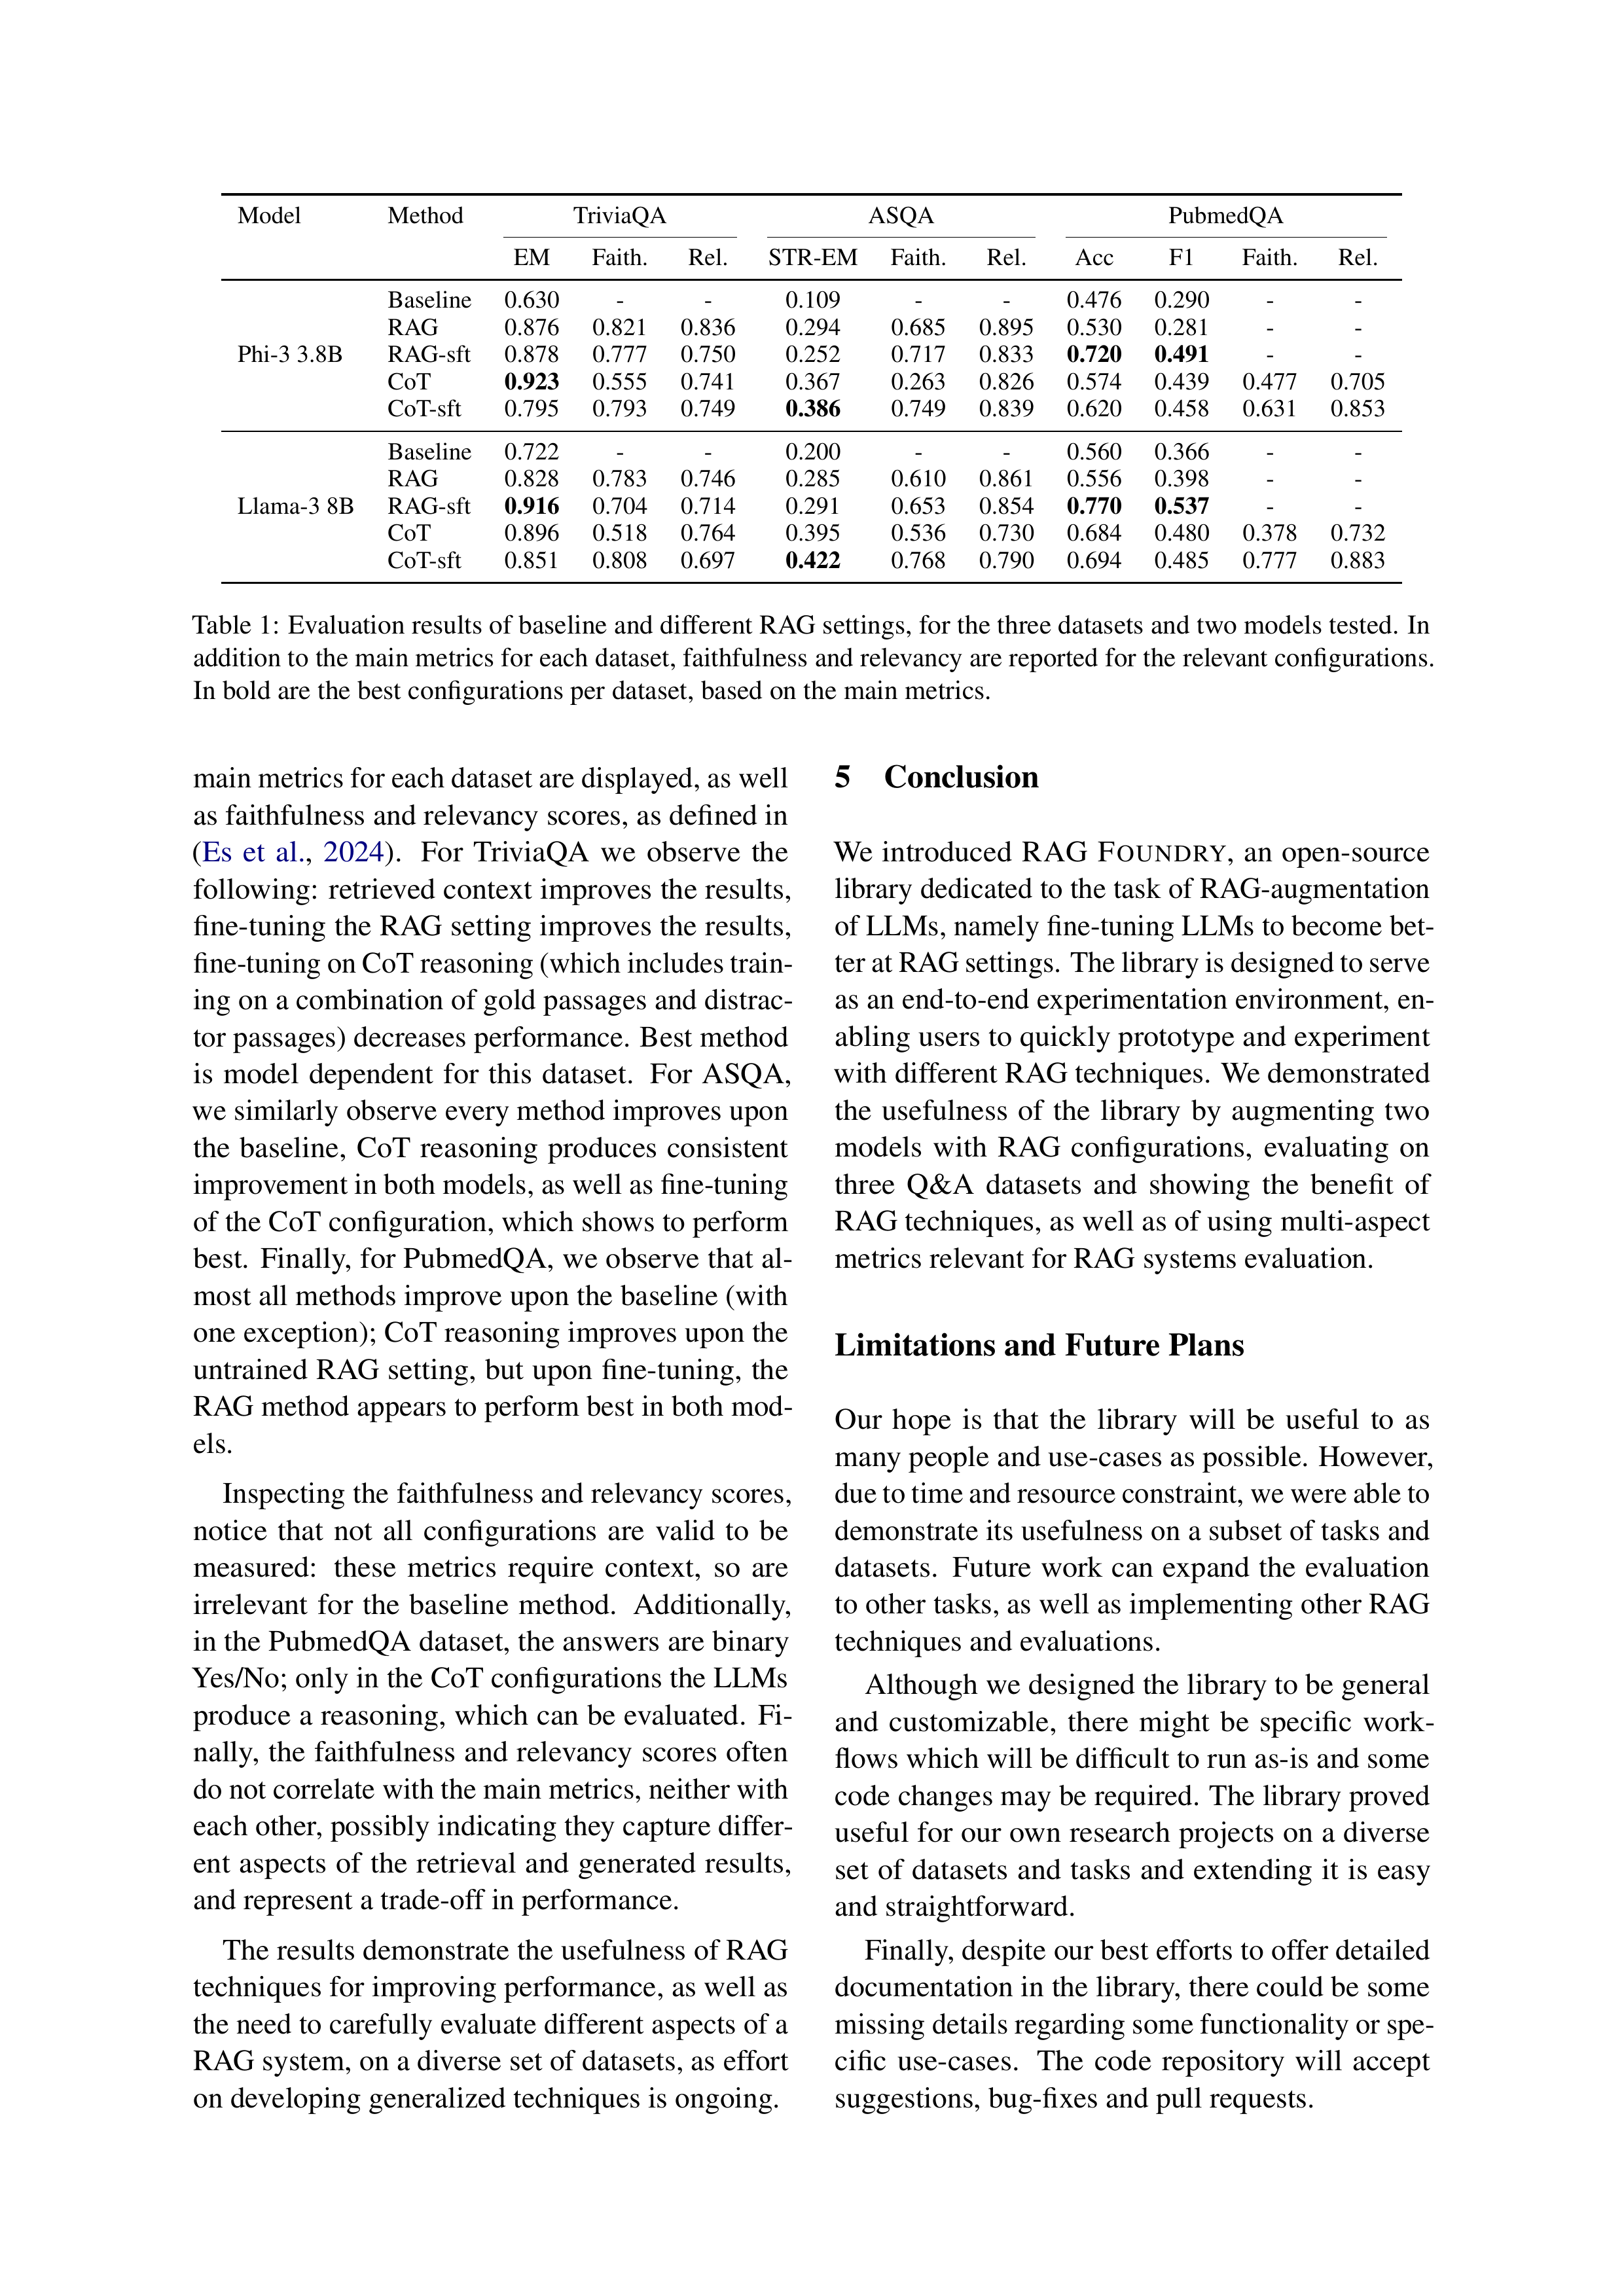

In [9]:
doc_img[5]

In [10]:
doc_text = []
for page in tqdm(doc_img):
    text = pytesseract.image_to_string(page, lang='eng')
    doc_text.append(text)

doc_text[5]

  0%|          | 0/10 [00:00<?, ?it/s]

'Model Method TriviaQA ASQA PubmedQA\nEM Faith. Rel. STR-EM Faith. Rel. Acc Fl Faith. _—_ Rel.\n\nBaseline 0.630 - - 0.109 - - 0.476 0.290 - -\nRAG 0.876 0.821 0.836 0.294 0.685 0.895 0.530 0.281 - -\n\nPhi-3 3.8B RAG-sft 0.878 0.777. 0.750 0.252 0.717. 0.833 0.720 (0.491 - -\nCoT 0.923 0.555 0.741 0.367 0.263 0.826 0.574 0.439 0.477 0.705\nCoT-sft 0.795 0.793 0.749 0.386 0.749 0.839 0.620 0.458 0.631 0.853\nBaseline 0.722 - - 0.200 - - 0.560 0.366 - -\nRAG 0.828 0.783 0.746 0.285 0.610 0.861 0.556 0.398 - -\n\nLlama-3 8B RAG-sft 0.916 0.704 0.714 0.291 0.653 0.854 0.770 0.537 - -\nCoT 0.896 0.518 0.764 0.395 0.536 0.730 0.684 0.480 0.378 0.732\nCoT-sft 0.851 0.808 0.697 0.422 0.768 0.790 0.694 0.485 0.777 0.883\n\nTable 1: Evaluation results of baseline and different RAG settings, for the three datasets and two models tested. In\naddition to the main metrics for each dataset, faithfulness and relevancy are reported for the relevant configurations.\nIn bold are the best configurations 

#### Preprocessing

In [11]:
title_map = {
    "1-2": "Introduction",
    "3-6": "Table of Contents",
    "7-10": "Study Details"
}

In [12]:
lst_docs, lst_ids, lst_metadata = [], [], []
for n,page in enumerate(doc_text):
    try:
        ## get title
        title = [v for k,v in title_map.items() if n in range(int(k.split("-")[0]), int(k.split("-")[1])+1)][0]
        ## clean page
        page = page.replace("Table of Contents","")
        ## get paragraph
        for i,p in enumerate(page.split('\n\n')):
            if len(p.strip())>5:
                lst_docs.append(p.strip())
                lst_ids.append(str(n)+"_"+str(i))
                lst_metadata.append({"title":title})
    except:
        continue

print(len(lst_docs), "=", len(lst_ids), "=", len(lst_metadata))

165 = 165 = 165


In [13]:
for id,doc,meta in zip(lst_ids[100:150], lst_docs[100:150], lst_metadata[100:150]):
    print(id, "-", meta, "\n", doc, "\n")

6_1 - {'title': 'Table of Contents'} 
 In conducting our research we strive abiding to
the highest ethical standards, including integrity,
fairness, and societal benefit of our work. We pri-
oritized data privacy and security throughout our
research; any data used in our experiments was
publicly available and did not contain any private
information. We are committed to the principles of
transparency and reproducibility; the methodolo-
gies, including data pre-processing, model training,
and evaluation are documented in order to enable
others to replicate our findings. Code is made avail-
able in an open repository. We advocate for the
responsible use of LLMs and RAG augmentation.
It is essential to exercise caution and verify the ac-
curacy and reliability of generated text produced by
LLMs. Hallucinations can have negative implica-
tions, and even when RAG methods can ameliorate
some of these aspects, verification and inspections
are needed. 

6_2 - {'title': 'Table of Contents'} 
 Re

#### LLM Generator

In [14]:
def keyword_generator(p, top=3):
    prompt = "summarize the following paragraph in 3 keywords separated by ,: "+p
    res = ollama.generate(model="llama3", prompt=prompt)["response"]
    #lst = [k.replace("\n"," ").strip() for k in res.split(",")][:top]
    #str = ", ".join(lst)
    return res.replace("\n"," ").strip()

p = '''We introduce RAG FOUNDRY, an open-source python framework for developing sophisticated retrieval-augmented LLMs for RAG use-cases. The library supports researchers and practitioners in the
nuanced task of enhancing the capabilities of LLMs in RAG use cases. It is highly customizable, facilitating rapid prototyping and experimentation across all aspects of RAG, including data selection, aggregation and filtering, retrieval, text processing,
document ranking, few-shot generation, prompt design using templates, fine-tuning, inference, and evaluation.'''
print(keyword_generator(p))

Here is a summary of the paragraph in 3 keywords separated by commas:  RAG, Python, Framework


In [15]:
for i,doc in tqdm(enumerate(lst_docs)):
    lst_metadata[i]["keywords"] = keyword_generator(doc)

0it [00:00, ?it/s]

In [16]:
for id,doc,meta in zip(lst_ids[100:150], lst_docs[100:150], lst_metadata[100:150]):
    print(id, "-", meta, "\n", doc, "\n")

6_1 - {'title': 'Table of Contents', 'keywords': 'Here are 3 keywords summarizing the paragraph: Ethics, Transparency, Verification'} 
 In conducting our research we strive abiding to
the highest ethical standards, including integrity,
fairness, and societal benefit of our work. We pri-
oritized data privacy and security throughout our
research; any data used in our experiments was
publicly available and did not contain any private
information. We are committed to the principles of
transparency and reproducibility; the methodolo-
gies, including data pre-processing, model training,
and evaluation are documented in order to enable
others to replicate our findings. Code is made avail-
able in an open repository. We advocate for the
responsible use of LLMs and RAG augmentation.
It is essential to exercise caution and verify the ac-
curacy and reliability of generated text produced by
LLMs. Hallucinations can have negative implica-
tions, and even when RAG methods can ameliorate
some of th

In [17]:
table = lst_docs[100]
print("Table:\n", table)

prompt = f"Summarize the following table: {table}"
res = ollama.generate(model="llama3", prompt=prompt)["response"]

print("\nSummary:\n", res)

Table:
 In conducting our research we strive abiding to
the highest ethical standards, including integrity,
fairness, and societal benefit of our work. We pri-
oritized data privacy and security throughout our
research; any data used in our experiments was
publicly available and did not contain any private
information. We are committed to the principles of
transparency and reproducibility; the methodolo-
gies, including data pre-processing, model training,
and evaluation are documented in order to enable
others to replicate our findings. Code is made avail-
able in an open repository. We advocate for the
responsible use of LLMs and RAG augmentation.
It is essential to exercise caution and verify the ac-
curacy and reliability of generated text produced by
LLMs. Hallucinations can have negative implica-
tions, and even when RAG methods can ameliorate
some of these aspects, verification and inspections
are needed.

Summary:
 The table describes the research methodology and ethical consid

#### Database

In [18]:
db = chromadb.PersistentClient()
db.list_collections()

[]

In [19]:
collection_name = "RAG_FOUNDRY"

if collection_name in [c.name for c in db.list_collections()]:
    db.delete_collection(collection_name)
    print("--- deleted ---")

collection = db.get_or_create_collection(name=collection_name, 
                                         embedding_function=chromadb.utils.embedding_functions.DefaultEmbeddingFunction())

collection.add(documents=lst_docs, ids=lst_ids, metadatas=lst_metadata, 
               images=None, embeddings=None)

collection.peek(1)

{'ids': ['1_0'],
 'embeddings': [[-0.10694852471351624,
   0.022407568991184235,
   0.020039593800902367,
   0.032201964408159256,
   -0.06169275939464569,
   -0.03671635687351227,
   -0.030920598655939102,
   -0.009627544321119785,
   -0.01764657534658909,
   -0.0565900020301342,
   -0.05442322790622711,
   0.011420536786317825,
   0.08608849346637726,
   -0.025517717003822327,
   -0.04376350715756416,
   0.04026149958372116,
   0.062132444232702255,
   0.07980799674987793,
   -0.07483604550361633,
   -0.08459673821926117,
   0.012542513199150562,
   0.07279956340789795,
   -0.018566204234957695,
   -0.05217931792140007,
   0.024744948372244835,
   0.022758139297366142,
   -0.03962671756744385,
   0.038904331624507904,
   0.07688824087381363,
   -0.0758943036198616,
   0.04370417818427086,
   0.09509246796369553,
   -0.01048758439719677,
   0.03754967823624611,
   -0.05476251244544983,
   0.10124573111534119,
   -0.039271943271160126,
   0.0078370850533247,
   -0.02499900758266449,
  

In [20]:
query = "Summarize the Introduction?"
collection.query(query_texts=[query])

{'ids': [['5_8',
   '8_8',
   '9_4',
   '4_17',
   '2_16',
   '6_2',
   '6_6',
   '9_10',
   '9_0',
   '6_10']],
 'distances': [[1.1187206506729126,
   1.2703391633475554,
   1.2789312861506006,
   1.2902911901474,
   1.304928183555603,
   1.314317357873764,
   1.32455644580775,
   1.3486228242973122,
   1.3782077844988168,
   1.3839028683776848]],
 'metadatas': [[{'keywords': "I'm happy to help! However, I don't see a paragraph provided. Please provide the paragraph you'd like me to summarize, and I'll do my best to condense it into 3 keywords separated by commas (e.g., keyword1, keyword2, keyword3).",
    'title': 'Table of Contents'},
   {'keywords': 'Here is a summary of the paragraph in 3 keywords separated by commas:  BERT, Evaluation, TextGeneration',
    'title': 'Study Details'},
   {'keywords': 'Here is a summary of the paragraph in 3 keywords separated by commas:  Documents, Context, Relevant',
    'title': 'Study Details'},
   {'keywords': 'Here is a summary of the paragrap

In [21]:
res_db = collection.query(query_texts=[query])["documents"][0][0:10]
context = ' '.join(res_db).replace("\n", " ")
context

'5 Conclusion Tianyi Zhang, Varsha Kishore, Felix Wu, Kilian Q. Weinberger, and Yoav Artzi. 2019. BERTScore: Evaluating Text Generation with BERT. ArXiv. Listing 6: Template for inserting relevant documents as context. guides the model to use the retrieved context, ex- plain the steps, quote relevant parts and produce a final answer. Complementing that, we explore fine-tuning recipes. We fine-tune the model in the RAG setup and denote is as RAG-sft. To comple- ment CoT, we implemented a fine-tuning recipe, denoted as CoT-sft, introduced in (Zhang et al., 2024), where gold documents and purely distractor documents are used in the prompt, determined by probability, in conjunction with a CoT prompt. All prompt templates are included in appendix A.1. * Local Steps: Operate on individual examples, making them suitable for tasks such as retrieval, text processing, and field manipulation. References Akari Asai, Zeqiu Wu, Yizhong Wang, Avirup Sil, and Hannaneh Hajishirzi. 2023. Self-rag: Learn

In [22]:
# Chat with Context only
res = ollama.chat(model="llama3", 
                  messages=[{"role":"system", "content":"Give the most accurate answer using only \
                                                         the folling information: \n"+context},
                            {"role":"user", "content":query}])
print(res["message"]["content"])

The introduction is not explicitly provided in the given text. However, based on the title "BERTScore: Evaluating Text Generation with BERT" and the subsequent description of fine-tuning recipes, it appears that the paper discusses an evaluation method for text generation using BERT (Bidirectional Encoder Representations from Transformers) and presents fine-tuning recipes to complement the model's performance.
